In [504]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from numpy.random import default_rng

### анализ данных по операциям с использованием кредитных карт, в том числе и мошенническим

### Из описания: таблица содержит данные о порядка 240 тыс операций по кредитным картам в Европе за два дня в сентябре 2013 года.
### из них всего 492 мошеннические операции. Поэтому сильный перекос в данных наблюдается сразу

### -------------------------------

### Анализ данных

### -------------------------------

In [505]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Какие-то V1 V2..., в душе не ..., что это

### посмотрим на пропуски

In [506]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### пропусков нет - это хорошо

### Данные по этим признакам как будто нормированы, посмотрим разброс значений каждого из столбцов

In [507]:
pd.concat([df.min(), df.max()],axis = 1)

,0,1
Time,0.000000,172792.000000
V1,-56.407510,2.454930
V2,-72.715728,22.057729
V3,-48.325589,9.382558
V4,-5.683171,16.875344
V5,-113.743307,34.801666
V6,-26.160506,73.301626
V7,-43.557242,120.589494
V8,-73.216718,20.007208
V9,-13.434066,15.594995


### наверное стоит потом отнормировать данные

### посмотрим корреляцию признаков

<Axes: >

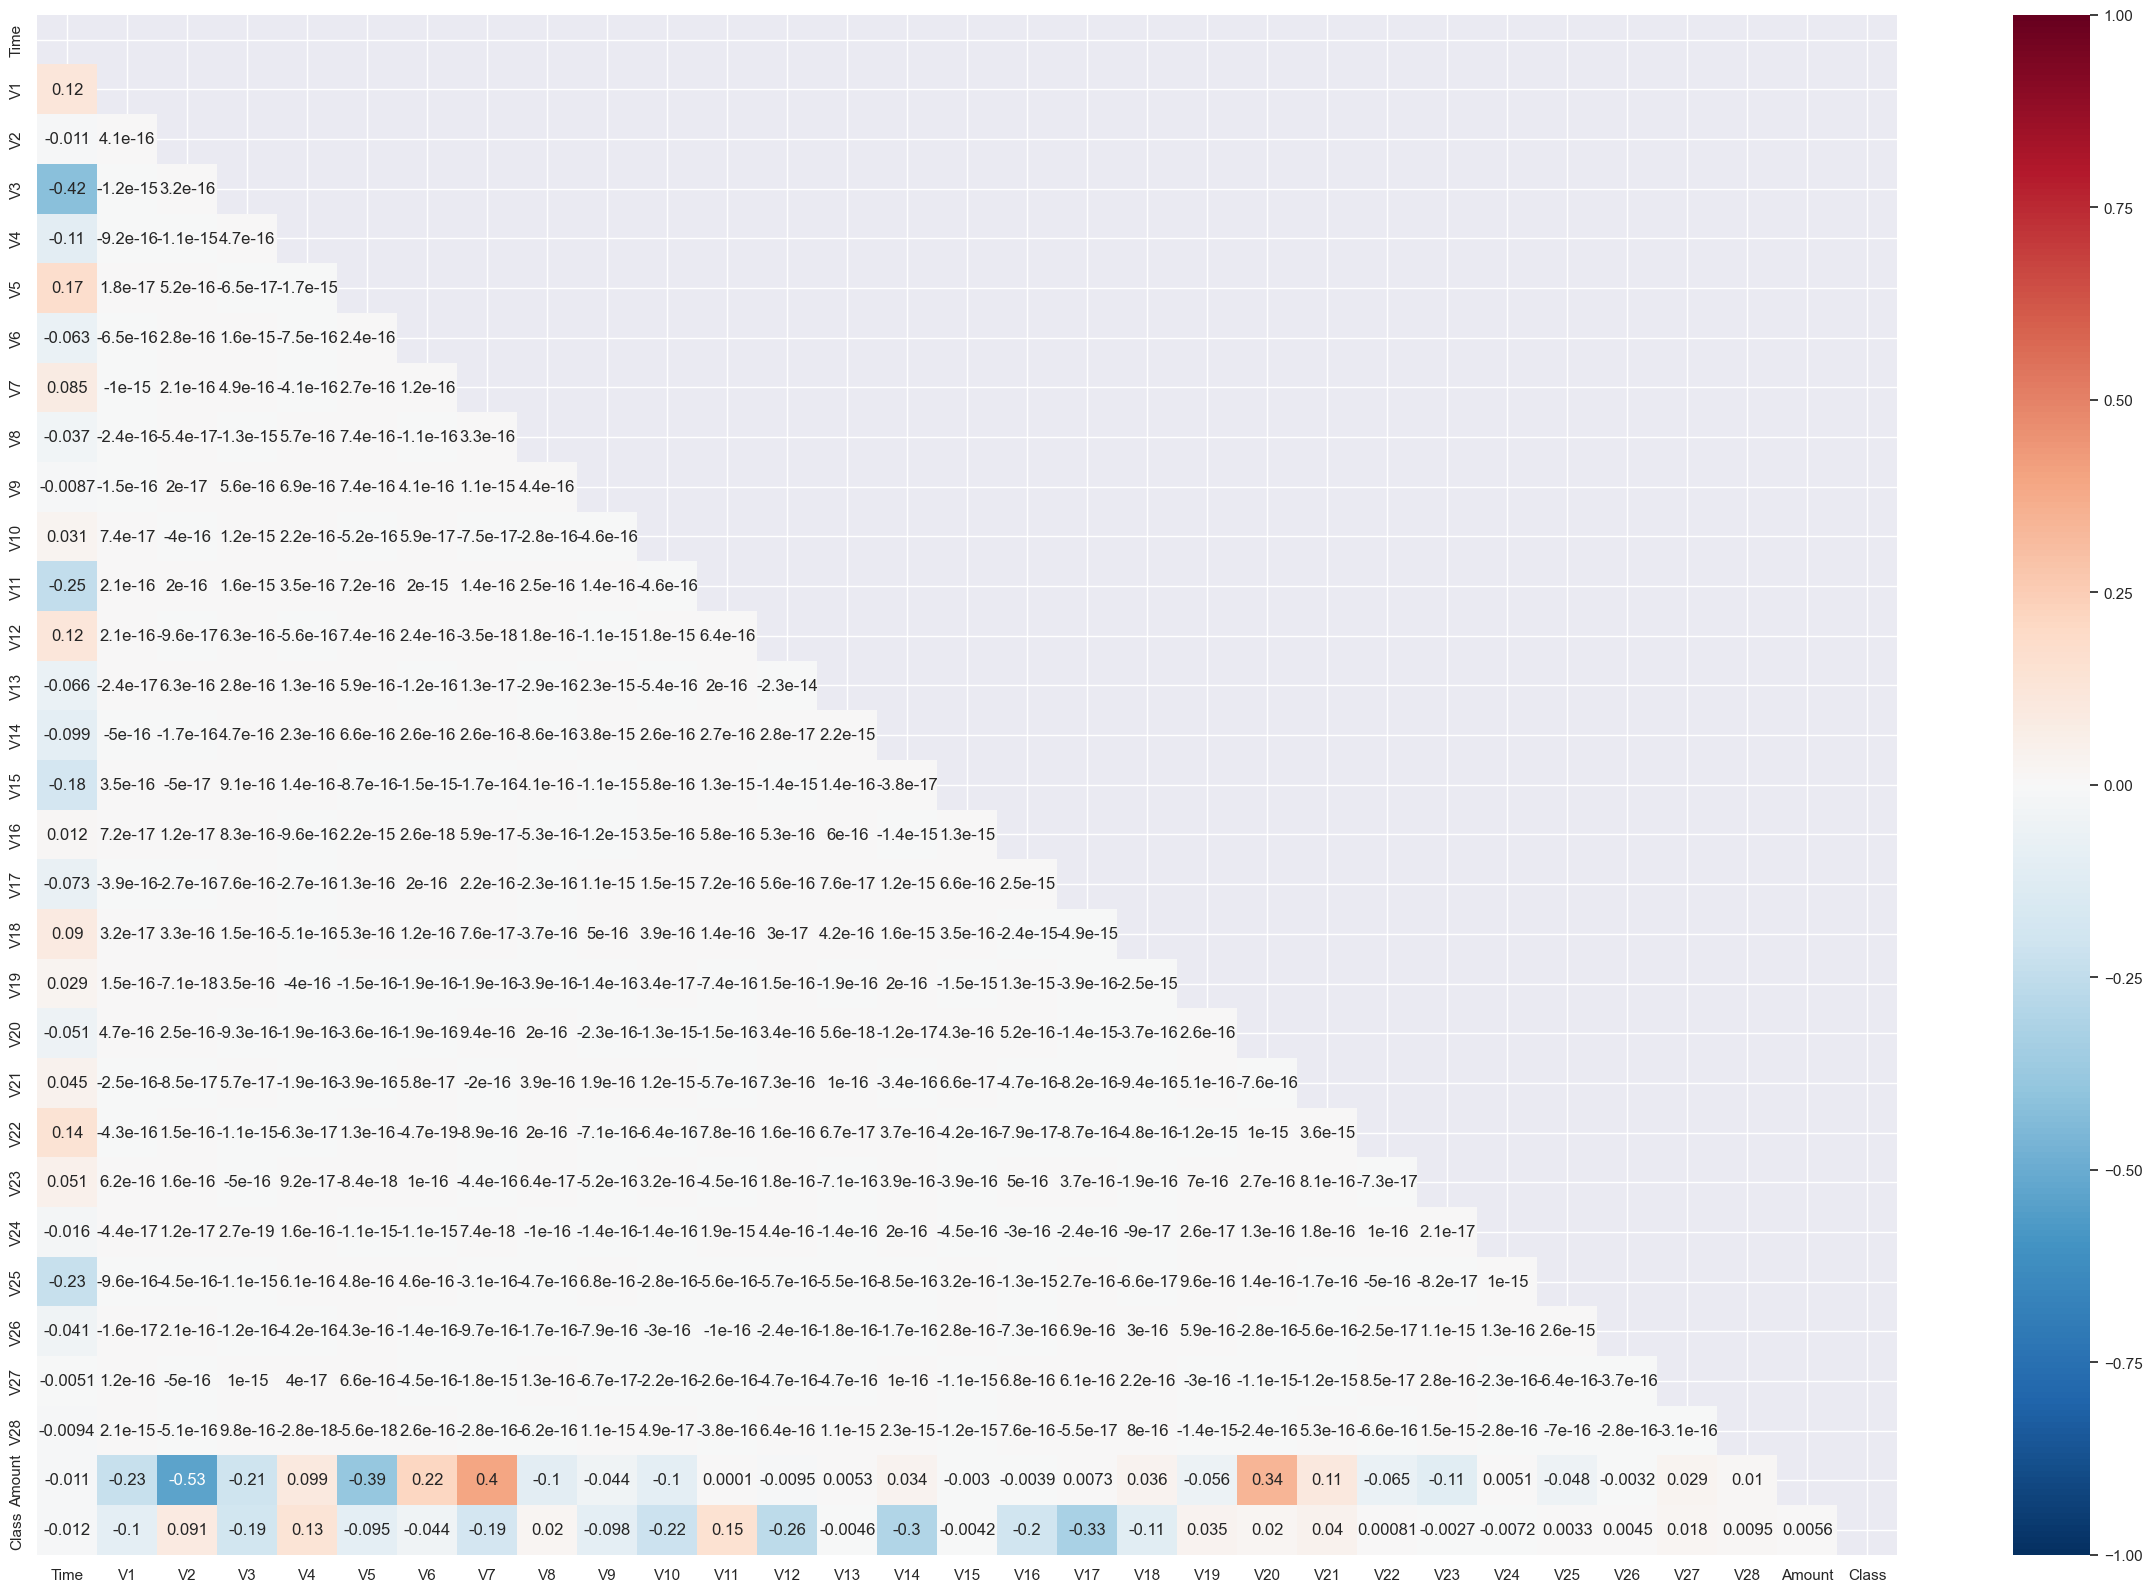

In [508]:
plt.figure(figsize=(30,20))
sns.set()
sns.heatmap(df.corr(), cmap='RdBu_r', annot=True, vmin=-1, vmax=1, mask=np.triu(df.corr()))

### Вывод: есть взаимосвязь между Class и V1-18. Плюс Amount связан с некоторыми признаками, поэтому его можно грохнуть
### Time тоже немного взаимосвязан с некоторыми признаками, можно попробовать его выкинуть

### Как говорилось в описании, данные сильно не сбалансированы, продемонстрируем это

Обычные 99.83 % данных
Мошенники: 0.17 % данных


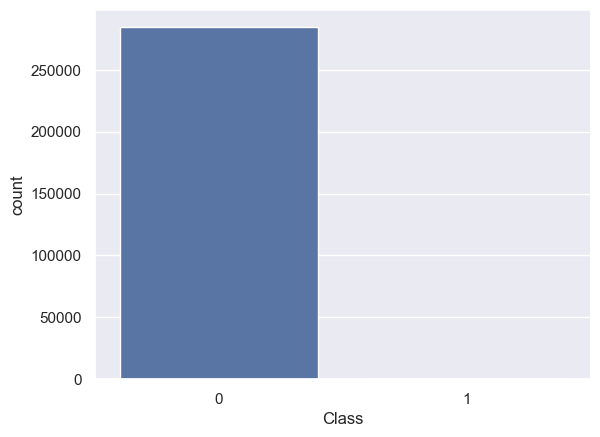

In [509]:
print('Обычные', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% данных')
print('Мошенники:', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% данных')
sns.countplot(df, x='Class')
plt.show()

### Выведем основные статистики признаков

In [510]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### -----------------------------
### Преобработка данных 
### -----------------------------

### изменим границы amount

In [511]:
from sklearn.preprocessing import StandardScaler
df['Amount'] = StandardScaler().fit_transform(np.array(df['Amount']).reshape(-1, 1))
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


### Уберем Time

In [512]:
df.drop(columns = 'Time', inplace = True)

### Сбалансируем датафрейм так, чтобы записей было поровну: отсечем немошеннические записи, оставив их в количестве мошеннических
### НО! сделаем это спартанским методом: переберем 100 случайных выборок и для каждой из них
### сравним средние относительные отклонения признаков от std и mean , min, max всех немошеннических записей
### потом выберем ту выборку, где меньше всего среднее относительное отклонение от std mean min max исходных немошеннических данных

In [513]:
### надо узнать, сколько записей мошеннических
number = len(df[df['Class'] == 1])
number

492

In [514]:
### отделяем мошеннические от немошеннических
X = df[df["Class"] == 0].copy()
Y = df[df["Class"] == 1].copy()

In [515]:
def find_best_X() -> [int]: 
    index_massive = []
    score = []
    df_to_check = X.agg(['mean', 'std', 'min', 'max'])
    for i in range(500):
        rng = default_rng()
        indexes = rng.choice(len(X), size=number, replace=False)
        index_massive.append(indexes)
        # считаем статистики датафрейма
        df_temp = X.iloc[indexes]
        # считаем среднюю относительную ошибку 
        otn_errors = (df_temp.agg(['mean', 'std', 'min', 'max'])-df_to_check).div(df_to_check)
        # сложим все относительные ошибки и поделим на их число
        res = 0
        k = 0
        for column in otn_errors.columns:
            for error in otn_errors[column]:
                if ((not math.isnan(error)) and (abs(error) < 1000)):
                    res = res + abs(error)
                    k = k+1           
        score.append(res/k)
    ### забираем индексы с наименьшим средним отклонениям от полного X
    TrueIndexes = index_massive[score.index(min(score))]
    return TrueIndexes
    

In [516]:
indexes = find_best_X()
print(len(X.iloc[indexes]))
print(len(Y))

492
492


### соединим в один датафрейм X и Y (мы ведь с X работали отдельно)

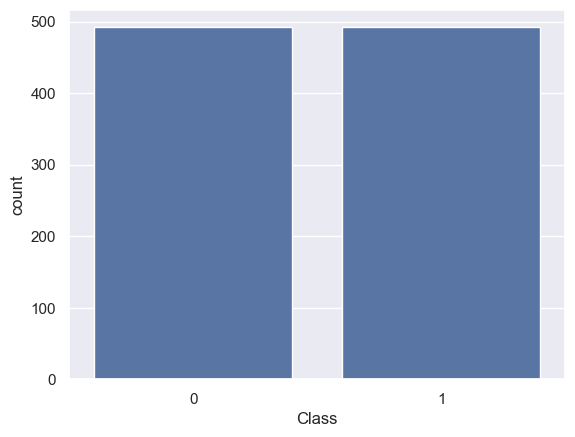

In [517]:
frames = [X.iloc[indexes], Y]
balanced_df = pd.concat(frames)
sns.countplot(balanced_df, x='Class' )
y = balanced_df["Class"]
balanced_df.drop(columns = "Class", inplace = True)

### Сравним метрики урезанного X с исходным X

In [518]:
X.iloc[indexes].agg(['mean', 'std', 'min', 'max'])-X.agg(['mean', 'std', 'min', 'max'])

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
mean,0.135412,-0.014684,0.004894,-0.050675,0.024224,0.042730,0.010876,0.015777,0.012269,-0.006670,...,-0.021488,-0.035870,-0.001555,-0.051471,0.002107,0.003232,-0.003117,-0.013224,-0.004048,0.0
std,-0.343942,-0.388057,-0.108279,-0.102673,-0.255186,-0.107687,-0.269853,-0.391074,-0.029648,-0.081846,...,-0.198088,-0.041620,-0.243021,0.016228,-0.030189,-0.015088,-0.139294,-0.090459,-0.214087,0.0
min,47.472616,66.388645,42.559896,2.028458,110.496999,22.340613,27.368217,68.151083,3.772412,12.533456,...,31.939349,8.963782,42.119671,0.403731,8.475228,1.273665,20.585595,13.186154,0.000000,0.0
max,-0.141958,-13.236042,-6.430389,-12.740535,-30.393961,-69.039914,-116.137060,-15.421549,-11.770618,-17.730392,...,-17.254150,-8.816139,-20.116461,-3.327492,-6.103940,-1.111458,-30.201341,-32.411634,-95.152173,0.0


### min и max сильно вылетают, но std и mean - нормальные, а значит такой разброс в макс и мин - это лишь выбросы в данных

### Теперь можем разделять на train и test

In [519]:
X_train, X_test, y_train, y_test = train_test_split(balanced_df, y, test_size=0.3)
data = [X_train, X_test, y_train, y_test]

### посмотрим на разницу характерных значений тестовой и тренировочной выборки

In [520]:
X_train.describe().loc[['mean', 'std', 'min', 'max']] - X_test.describe().loc[['mean', 'std', 'min', 'max']]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
mean,-0.029938,-0.124416,-0.011570,-0.104223,-0.119425,0.074330,-0.018382,0.239345,0.050701,-0.042374,...,-0.119146,0.097912,-0.015257,-0.072820,-0.047213,0.071282,0.006960,0.004470,-0.043510,0.014173
std,0.319080,-0.072982,0.355063,-0.061545,0.059524,0.005689,0.128510,-0.053172,0.073616,0.117666,...,-0.185267,0.153415,0.010411,0.469644,0.030392,-0.038148,-0.058707,0.059253,-0.017433,0.113432
min,-1.843151,1.243112,-2.179929,-0.233021,-1.759303,0.975295,2.050445,2.056998,-0.113912,0.185077,...,0.635136,1.343868,0.000000,-14.965689,0.202091,-2.701677,0.180962,-1.581144,0.447567,0.000000
max,-0.001288,-0.590526,0.624052,0.249804,1.214525,-0.408213,2.214506,1.677803,0.023761,0.419148,...,-0.618286,0.000000,0.045710,-0.162623,-0.153646,0.208710,-0.339373,0.700024,0.258145,1.357270


### -----------------------------
### Обучение моделей и подсчет метрик
### -----------------------------

### попробуем дерево решений 

In [521]:
from sklearn.metrics import roc_auc_score, classification_report

In [522]:
metric = roc_auc_score
def DecTree(df1,df2):
    X_train, X_test, y_train, y_test = train_test_split(df1, df2, test_size=0.3)
    regressor = DecisionTreeClassifier()
    regressor.fit(X_train, y_train)
    y_predict = regressor.predict(X_test)
    score = metric(y_test, y_predict)
    return score
res2 = DecTree(balanced_df, y)
res2

0.9256756756756758

### попробуем и другие классификаторы 

In [523]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb

In [524]:
names_of_models = ["LogReg", "KNeigh", "SVC", "DecTree", "RandForest", "XGBoost"]

In [525]:
def apply_models():
    models = [LogisticRegression, KNeighborsClassifier, SVC, DecisionTreeClassifier, RandomForestClassifier, xgb.XGBClassifier]
    metrics = []
    fitted_models = []
    reports = []
    
    def model_applying(model, data_):
        try:
            model = model(n_jobs=-1)
        except:
            model = model(random_state=42)
    
        model.fit(data_[0], data_[2])
        pred = model.predict(X_test)
        reports.append(classification_report(y_true=y_test, y_pred= pred))
        return pred, model
    
    for model in models:
        pred, mod = model_applying(model, data)
        metrics.append(metric(y_test, pred))
        fitted_models.append(mod)
        
    return metrics, fitted_models, reports

In [526]:
mcs1, models1, reports = apply_models()
mcs1

[0.9459459459459459,
 0.9391891891891893,
 0.9628378378378378,
 0.9155405405405405,
 0.9459459459459459,
 0.9324324324324325]

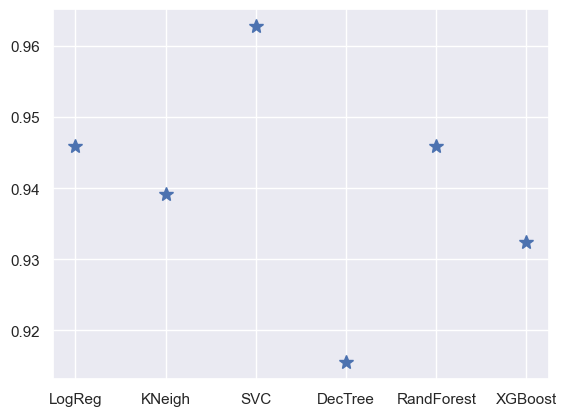

In [528]:
plt.plot(names_of_models, mcs1, "*", markersize=10)

### подробный отчет по SVC:

In [531]:
best_score = max(mcs1)
ind = mcs1.index(best_score)
print(reports[ind])

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       148
           1       0.99      0.93      0.96       148

    accuracy                           0.96       296
   macro avg       0.96      0.96      0.96       296
weighted avg       0.96      0.96      0.96       296



### Теперь если убрать Amount

In [532]:
X_train.drop(columns="Amount", inplace=True)
X_test.drop(columns="Amount", inplace=True)
y_train.drop(columns="Amount", inplace=True)
y_test.drop(columns="Amount", inplace=True)

In [533]:
data = [X_train, X_test, y_train, y_test]

In [534]:
mcs, models, reports = apply_models()
mcs

[0.9459459459459459,
 0.9425675675675677,
 0.9628378378378378,
 0.9087837837837838,
 0.9425675675675674,
 0.9391891891891891]

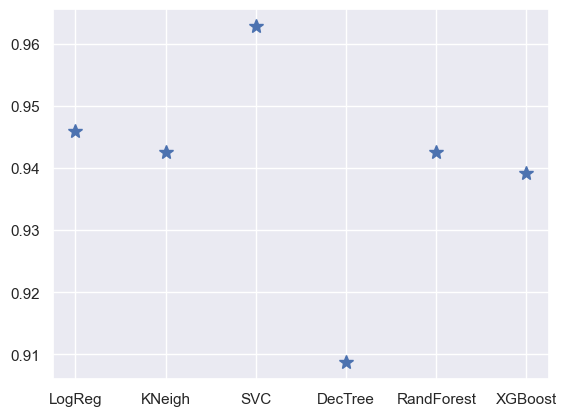

In [535]:
plt.plot(names_of_models, mcs, "*", markersize=10)

In [536]:
### Выведем подробный отчет по SVC

best_score = max(mcs)
ind = mcs.index(best_score)
print(reports[ind])

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       148
           1       0.99      0.93      0.96       148

    accuracy                           0.96       296
   macro avg       0.96      0.96      0.96       296
weighted avg       0.96      0.96      0.96       296



### -------
### Проверим на случайной выборке из всего датасета

In [538]:
frac_df = df.sample(frac=0.05) ### берем 5 процентов от данных


In [544]:
y_full_test = frac_df['Class']
X_full_test = frac_df.drop(columns='Class')
X_full_test.drop(columns='Amount', inplace=True)

In [547]:
best_model = models[ind]
print('ROC AUC:', roc_auc_score(y_true=y_full_test, y_score=best_model.predict(X_full_test)))

ROC AUC: 0.9615790213723285


### подробный отчет

In [549]:
print(classification_report(y_true=y_full_test, y_pred=best_model.predict(X_full_test)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     14224
           1       0.07      0.94      0.13        16

    accuracy                           0.99     14240
   macro avg       0.53      0.96      0.56     14240
weighted avg       1.00      0.99      0.99     14240



Низкий precision и f1 из-за несбалансированности датафрейма. Чудовищной.

### На данной выборке лучше всего справилась модель SVC. Но на самом деле, если брать другую выборку, может и XGBoost лучше справляться.
### Главное что метрика всегда находится в диапазоне от 0.91-0.96.
### 

### Есть ли резон проверять не семплированных данных?
### В отличие от отбалансированного датафрейма, где мы оставили маленькое количество немошеннических записей,
### семплированный датафрейм содержит перекос в данных сопоставимый с исходным,
### поэтому проверяя на нем, мы начинаем учитывать то, что большинство операций у нас немошеннические, что
### соответствует исходным данным. Поэтому я считаю, что резонно проверять обученную модель на бОльшей выборке из исходного датафрейма